In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

# Super-resolution (training)

## Setup

In [3]:
# # Run this to download DIV2K dataset and saving it to your gdrive
# ! wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
# ! wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip
# ! wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
# ! wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

# ! mkdir div2k
# ! unzip -q DIV2K_valid_LR_bicubic_X2.zip -d div2k
# ! unzip -q DIV2K_train_LR_bicubic_X2.zip -d div2k
# ! unzip -q DIV2K_train_HR.zip -d div2k
# ! unzip -q DIV2K_valid_HR.zip -d div2k

In [4]:
! pip install -q ISR

     |████████████████████████████████| 86.3MB 51kB/s 
     |████████████████████████████████| 450kB 40.0MB/s 
     |████████████████████████████████| 3.8MB 43.5MB/s 
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [5]:
from google.colab import drive
import os, sys
from pathlib import Path
import numpy as np
import PIL
import matplotlib.pyplot as plt

In [6]:
drive.mount('/content/drive')
dir_mydrive = Path('/content/drive/My Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
def _cp(src, dst):
    import shutil
    assert src.is_file()
    shutil.copy(src, dst)

Path.cp = _cp
Path.ls = lambda x: list(x.iterdir())

## Quick look at dataset

In [8]:
dir_data = dir_mydrive/'div2k' #Path('/content/div2k')
dir_lr_trn = dir_data/'DIV2K_train_LR_bicubic'/'X2'
dir_hr_trn = dir_data/'DIV2K_train_HR'
dir_lr_val = dir_data/'DIV2K_valid_LR_bicubic'/'X2'
dir_hr_val = dir_data/'DIV2K_valid_HR'

Just select a small subset of the original dataset.

In [9]:
trn_ids = sorted(n.stem for n in dir_hr_trn.ls())[:20]
val_ids = sorted(n.stem for n in dir_hr_val.ls())[:5]

In [10]:
def get_same_view(img_hr, img_lr, b0_hr=None, b1_hr=None):
    '''
    Grab the same corresponding area from the high and low
    resolution images.

    `img_hr`: np.array
        High resolution image.
    `img_lr`: np.array
        Low resolution image.
    `b0_hr`: tuple
        Lower and upper index to subsection dimension 0 
        of high resolution image.
    `b1_hr`: tuple
        Lower and upper index to subsection dimension 1 
        of high resolution image.
    '''
    if b0_hr is None: 
        b0_hr = (0, img_hr.shape[0])
    if b1_hr is None: 
        b1_hr = (0, img_hr.shape[1])
    for b, l in zip((b0_hr, b1_hr), img_hr.shape[:2]):
        assert 0 <= b[0] < b[1] <= l
    assert img_hr.shape[0]//img_lr.shape[0] == img_hr.shape[1]//img_lr.shape[1]
    scale = img_hr.shape[0]//img_lr.shape[0]
    b0_lr = tuple(l//scale for l in b0_hr)
    b1_lr = tuple(l//scale for l in b1_hr)
    img_hr_ = img_hr[slice(*b0_hr),slice(*b1_hr)]
    img_lr_ = img_lr[slice(*b0_lr),slice(*b1_lr)]
    return img_hr_, img_lr_

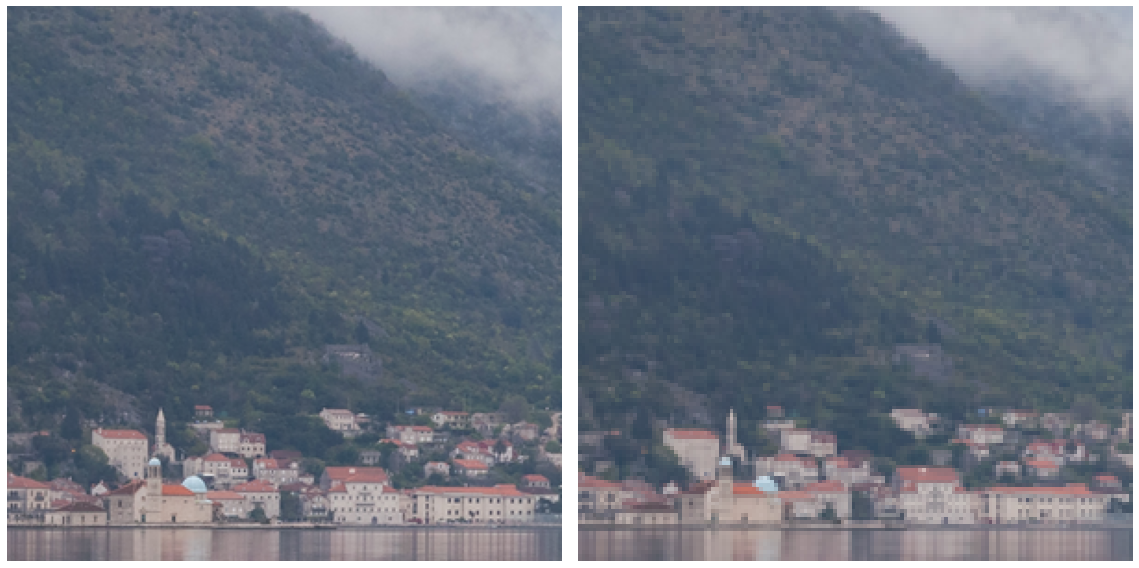

In [11]:
idx = 3

imgid = trn_ids[idx]
fn_hr, fn_lr = dir_hr_trn/f'{imgid}.png', dir_lr_trn/f'{imgid}x2.png'
img_hr = np.array(PIL.Image.open(fn_hr))
img_lr = np.array(PIL.Image.open(fn_lr))

img_hr_, img_lr_ = get_same_view(img_hr, img_lr, b0_hr=(500, 800), b1_hr=(200, 500))

nrows, ncols = 1, 2
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 8))
for ax in axs: ax.axis('off')

for i, img in enumerate([img_hr_, img_lr_]):
    axs[i%ncols].imshow(img)

plt.tight_layout();

## Copy dataset subset to `/content` to work with

In [12]:
srcs_lr_trn = [dir_lr_trn/f'{id}x2.png' for id in trn_ids]
srcs_hr_trn = [dir_hr_trn/f'{id}.png' for id in trn_ids]
srcs_lr_val = [dir_lr_val/f'{id}x2.png' for id in val_ids]
srcs_hr_val = [dir_hr_val/f'{id}.png' for id in val_ids]

In [13]:
dir_lr_trn_ = Path('/content/imgs_lr_trn'); dir_lr_trn_.mkdir(exist_ok=True)
dir_hr_trn_ = Path('/content/imgs_hr_trn'); dir_hr_trn_.mkdir(exist_ok=True)
dir_lr_val_ = Path('/content/imgs_lr_val'); dir_lr_val_.mkdir(exist_ok=True)
dir_hr_val_ = Path('/content/imgs_hr_val'); dir_hr_val_.mkdir(exist_ok=True)

In [14]:
for n in srcs_lr_trn: n.cp(dir_lr_trn_/n.name)
for n in srcs_hr_trn: n.cp(dir_hr_trn_/n.name)
for n in srcs_lr_val: n.cp(dir_lr_val_/n.name)
for n in srcs_hr_val: n.cp(dir_hr_val_/n.name)

In [15]:
dir_lr_trn = dir_lr_trn_
dir_hr_trn = dir_hr_trn_
dir_lr_val = dir_lr_val_
dir_hr_val = dir_hr_val_

## Generate x4 low resolution counterparts

In [16]:
def scale_image(img, scale=1, resample=PIL.Image.BICUBIC):
    new_size = tuple(int(scale * l) for l in img.size)
    return img.resize(size=new_size, resample=resample)

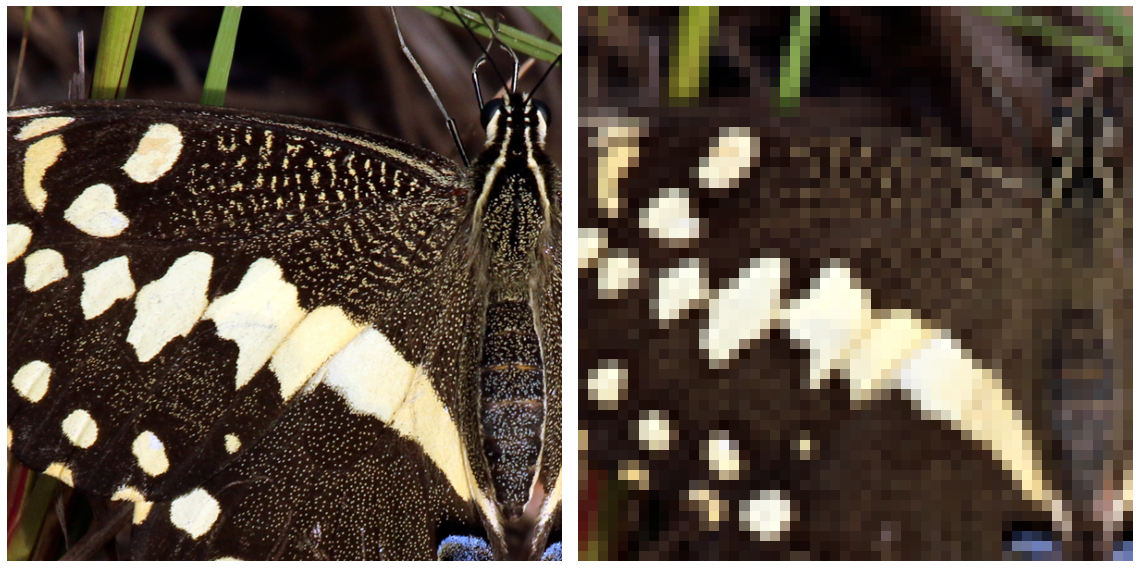

In [17]:
imgh = PIL.Image.open(dir_hr_trn.ls()[6])
imgl = scale_image(imgh, scale=1/11, )
imgh, imgl = np.array(imgh), np.array(imgl)

imgh_, imgl_ = get_same_view(imgh, imgl, b0_hr=(350, 950), b1_hr=(500, 1100))

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs = axs.flatten()
for ax, img in zip(axs, [imgh_, imgl_]):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout();

In [18]:
for p in dir_lr_trn.ls(): p.unlink()
for p in dir_lr_val.ls(): p.unlink()

In [19]:
def make_lr_images(dir_hr, dir_lr, factor):
    for p in dir_hr.ls():
        img_hr = PIL.Image.open(p)
        img_lr = scale_image(img_hr, 1/factor)
        img_lr.save(dir_lr/f'{p.stem}x{factor}.png')

In [20]:
make_lr_images(dir_hr_trn, dir_lr_trn, 4)
make_lr_images(dir_hr_val, dir_lr_val, 4)

In [21]:
dir_lr_val.ls()

[PosixPath('/content/imgs_lr_val/0802x4.png'),
 PosixPath('/content/imgs_lr_val/0803x4.png'),
 PosixPath('/content/imgs_lr_val/0805x4.png'),
 PosixPath('/content/imgs_lr_val/0801x4.png'),
 PosixPath('/content/imgs_lr_val/0804x4.png')]

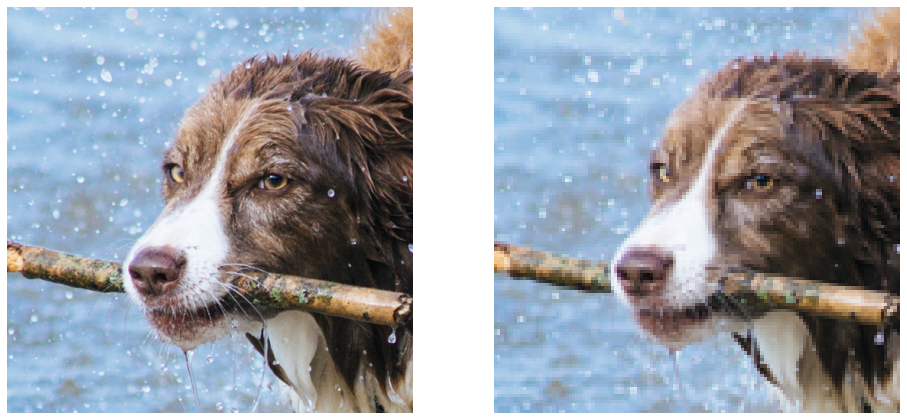

In [22]:
idx = 7
fn_hr = dir_hr_trn.ls()[idx]
fn_lr = dir_lr_trn/f'{fn_hr.stem}x4.png'
img_hr = np.array(PIL.Image.open(fn_hr))
img_lr = np.array(PIL.Image.open(fn_lr))

img_hr_, img_lr_ = get_same_view(img_hr, img_lr, b0_hr=(300, 800), b1_hr=(400, 900))

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs = axs.flatten()
for ax, img in zip(axs, (img_hr_, img_lr_)):
    ax.imshow(img)
    ax.axis('off')

## Training

In [23]:
from ISR.models import RRDN
from ISR.models import Discriminator
from ISR.models import Cut_VGG19
from ISR.train import Trainer

In [ ]:
RRDN??

In [24]:
lr_train_patch_size = 40
layers_to_extract = [5, 9]
scale = 4
hr_train_patch_size = lr_train_patch_size * scale

rrdn  = RRDN(arch_params={'C':4, 'D':3, 'G':64, 'G0':64, 'T':10, 'x':scale}, patch_size=lr_train_patch_size)
f_ext = Cut_VGG19(patch_size=hr_train_patch_size, layers_to_extract=layers_to_extract)
discr = Discriminator(patch_size=hr_train_patch_size, kernel_size=3)

ModuleNotFoundError: ignored

In [ ]:
loss_weights = {
  'generator': 0.0,
  'feature_extractor': 0.0833,
  'discriminator': 0.01
}
losses = {
  'generator': 'mae',
  'feature_extractor': 'mse',
  'discriminator': 'binary_crossentropy'
}

log_dirs = {'logs': './logs', 'weights': './weights'}

learning_rate = {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}

flatness = {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}

trainer = Trainer(
    generator=rrdn,
    discriminator=discr,
    feature_extractor=f_ext,
    lr_train_dir=dir_lr_trn, #'low_res/training/images',
    hr_train_dir=dir_hr_trn, #'high_res/training/images',
    lr_valid_dir=dir_lr_val, #'low_res/validation/images',
    hr_valid_dir=dir_hr_val, #'high_res/validation/images',
    loss_weights=loss_weights,
    learning_rate=learning_rate,
    flatness=flatness,
    dataname='image_dataset',
    log_dirs=log_dirs,
    weights_generator=None,
    weights_discriminator=None,
    n_validation=4,
    # n_validation=40
)

In [ ]:
trainer.train(
    epochs=1,
    steps_per_epoch=20,
    batch_size=4,
    monitored_metrics={'val_generator_PSNR_Y': 'max'}
)


Training details:
  training_parameters: 
    metrics: {'generator': <function PSNR_Y at 0x7f723dc1d378>}
    losses: {'generator': 'mae', 'discriminator': 'binary_crossentropy', 'feature_extractor': 'mse'}
    adam_optimizer: {'beta1': 0.9, 'beta2': 0.999, 'epsilon': None}
    learning_rate: {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}
    flatness: {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}
    n_validation: 4
    dataname: image_dataset
    fallback_save_every_n_epochs: 2
    log_dirs: {'logs': './logs', 'weights': './weights'}
    loss_weights: {'generator': 0.0, 'feature_extractor': 0.0833, 'discriminator': 0.01}
    hr_valid_dir: /content/imgs_hr_val
    lr_valid_dir: /content/imgs_lr_val
    hr_train_dir: /content/imgs_hr_trn
    lr_train_dir: /content/imgs_lr_trn
    lr_patch_size: 40
    steps_per_epoch: 20
    batch_size: 4
    starting_epoch: 0
  generator: 
    name: rrdn
    parameters: {'C': 4, 'D': 3, 'G': 64, 'G0': 64,

Epoch 0/1
Current learning rate: 0.00039999998989515007
100%|██████████| 20/20 [15:05<00:00, 45.30s/it]
Epoch 0 took      905.9s


16/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 32s 2s/sample - loss: 0.7851 - generator_loss: 0.4495 - discriminator_loss: 0.0106 - feature_extractor_loss: 2.9792 - feature_extractor_1_loss: 17.8418 - generator_PSNR_Y: 7.3945


{'val_loss': 0.867301732301712, 'val_generator_loss': 0.44946235, 'val_discriminator_loss': 0.010641357, 'val_feature_extractor_loss': 2.979193, 'val_feature_extractor_1_loss': 17.841824, 'val_generator_PSNR_Y': 7.3944516, 'train_d_real_loss': 0.021015022, 'train_d_real_accuracy': 1.0, 'train_d_fake_loss': 0.020468216, 'train_d_fake_accuracy': 1.0, 'train_loss': 0.74616015, 'train_generator_loss': 0.3885433, 'train_discriminator_loss': 0.009934256, 'train_feature_extractor_loss': 2.4900093, 'train_feature_extractor_1_loss': 15.422615, 'train_generator_PSNR_Y': 8.324375}
val_generator_PSNR_Y improved from       -inf to    7.39445
Saving weights


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1742013435565961093, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9188588226253775978
 physical_device_desc: "device: XLA_CPU device"]

In [ ]:
! ls weights/rrdn-C4-D3-G64-G064-T10-x4/2020-07-29_0207/

rrdn-C4-D3-G64-G064-T10-x4_best-val_generator_PSNR_Y_epoch001.hdf5
session_config.yml
srgan-large_best-val_generator_PSNR_Y_epoch001.hdf5


In [ ]:
path_weights = Path('weights/rrdn-C4-D3-G64-G064-T10-x4/2020-07-29_0207/rrdn-C4-D3-G64-G064-T10-x4_best-val_generator_PSNR_Y_epoch001.hdf5')
model = RRDN(arch_params={'C':4, 'D':3, 'G':64, 'G0':64, 'T':10, 'x':scale})
model.model.load_weights(str(path_weights))

In [ ]:
# imid = '0875'
# fn_lr = dir_lr_val/f'{imid}x2.png'
# fn_hr = dir_hr_val/f'{imid}.png'

In [ ]:
# plt.imshow(np.array(PIL.Image.open(fn_lr)), interpolation='none')
# plt.axis('off');

In [ ]:
# plt.imshow(np.array(PIL.Image.open(fn_hr)), interpolation='none')
# plt.axis('off');

In [ ]:
dir_tiles = (dir_mydrive/'Official Folder for Engie project/Data/'
/'Satellite Imagery'/'Main Island'/'JPEG_tiles_Main')

In [ ]:
fns = list(dir_tiles.rglob('*.jpeg'))
len(fns)

2208

In [ ]:
idx = 413
img = PIL.Image.open(fns[idx])

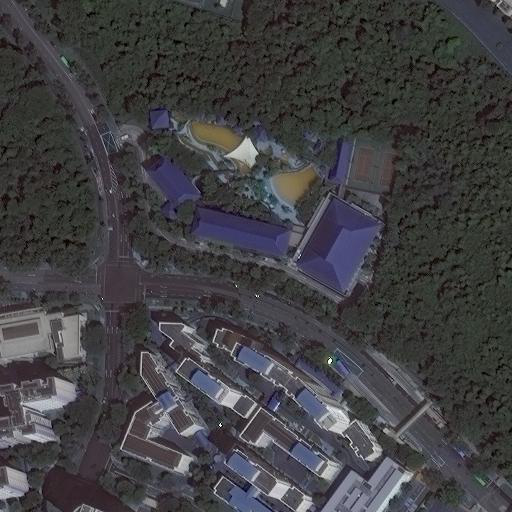

In [ ]:
img

In [ ]:
%%time
sr_img = model.predict(np.array(img), by_patch_of_size=50)

CPU times: user 9min 58s, sys: 1.88 s, total: 10min
Wall time: 5min 8s


In [ ]:
PIL.Image.fromarray(sr_img)

Output hidden; open in https://colab.research.google.com to view.